# Predicting Gout During Emergency Room Visit:  <i>Is the patient potentially suffering from Gout?</i>  

## Scope

The scope of this project is corpora from the Deep South.  The demographics of the population from which they were derived are 54% female, and 46% male, 55% Black, 40% White, 2% Hispanic, and 1% Asian. Age distribution was 5% between ages 1-20 years, 35% between ages 21-40 years, 35% between ages 41-60 years, 20% between ages 61-80 years, and 5% between ages 81-100 years.

## Data

The data is extracted in csv format from the MIMIC-III (Medical Information Mart for Intensive Care III) database.  Details can be found at https://physionet.org/content/emer-complaint-gout/1.0/.   Acces to the database may be requested at (https://mimic.physionet.org/gettingstarted/access/). 

The data provided by the MIMIC database consists of 2 corpora of free text collected by the triage nurse and recorded as the "Chief Complaint".  Each complaint contains up to 282 characters in length and was collected from 2019 to 2020 at an academic medical center in the Deep South.  The 2019 corpora, "GOUT-CC-2019-CORPUS", consists of 300 chief complaints selected by the presence of the keyword "gout". The 2020 corpora, "GOUT-CC-2020-CORPUS" contains 8037 chief complaints collected from a single month in 2020. The chief complaints included in both corpora were selected based on the presence of the keyword "gout".

## Cleaning

***Import Data***

In [1]:
import pandas as pd
syn2019 = pd.read_csv('Data/GOUT-CC-2019-CORPUS-SYNTHETIC.csv')
syn2020 = pd.read_csv('Data/GOUT-CC-2020-CORPUS-SYNTHETIC.csv')


**Data Description**
* 2 csv files
    * 2019 : 300 records
    * 2020 : 8037 records
    * Identical layouts and formats: all text, 3 columns
    <br><br>
* 3 Columns:  ["Chief Complaint", "Predict", "Consensus"]
    * <b>Chief Complaint:</b> 
        * text format
        * up to 282 Chars
        * nurse recorded patient complaint
    * <b>Predict:</b> 
        * text format
        * single char ('-','U','Y','N')
        * prediction of Gout by the ER Physician
    * <b>Consensus:</b> 
        * textformat
        * single char ('-','U','Y','N')
        * determination of Gout by the Rhuematologist
    <br>
* 
          - : Null
          U : Unknonw
          Y : Yes
          N : Gout

***Review Data***

In [2]:
print(syn2019.head())

                                     Chief Complaint Predict Consensus
0  "been feeling bad" last 2 weeks & switched BP ...       N         -
1  "can't walk", reports onset at 0830 am. orient...       Y         N
2  "dehydration" Chest hurts, hips hurt, cramps P...       Y         Y
3  "gout flare up" L arm swelling x 1 week. denie...       Y         Y
4  "heart racing,"dyspnea, and orthopnea that has...       N         -


In [3]:
print(syn2020.head())

                                     Chief Complaint Predict Consensus
0  "I dont know whats going on with my head, its ...       N         -
1  "i've been depressed for a few weeks now, i'm ...       N         -
2  Altercation while making arrest, c/o R hand pa...       N         N
3  Cut on L upper thigh wtih saw. Bleeding contro...       N         N
4   Dysuria x1 week. hx: hysterectomy, gerd, bipolar       N         -


***Combine into 1 dataframe 'df'***

In [4]:
# Combine the files into 1 dataframe
df = pd.concat([syn2019, syn2020], axis=0).reset_index(drop=True)
print(df.shape)

(8437, 3)


In [5]:
print(df.dtypes)

Chief Complaint    object
Predict            object
Consensus          object
dtype: object


## Clean Data

   * Remove records that contain null values in both of the Predict and Consensus columns.
   * Fill Consensus null values ( - ) with Predict values
   * Change all chars to lowercase
   * Remove punctuation
   * Remove words containing numbers

In [6]:
print(df['Predict'].value_counts(sort=False))

-       2
N    8168
U     156
Y     111
Name: Predict, dtype: int64


In [7]:
print(df['Consensus'].value_counts(sort=False))

-    7976
N     350
U      16
Y      95
Name: Consensus, dtype: int64


In [8]:
df = df[(df.Consensus != '-') | (df.Predict != '-')]
print(df.shape)

(8435, 3)


In [9]:
for a in df['Consensus']:
    if a == '-':
        df['Consensus'] = df['Predict']

In [10]:
df = df[(df.Predict != 'U') | (df.Consensus != 'U')]

In [11]:
print(df['Consensus'].value_counts(sort=False))

N    8168
Y     111
Name: Consensus, dtype: int64


In [12]:
df = df.drop(columns=['Predict'])

In [13]:
df = df.rename(columns={'Chief Complaint': 'corpus', 'Consensus': 'target'})
df

,corpus,target
0,"""been feeling bad"" last 2 weeks & switched BP ...",N
1,"""can't walk"", reports onset at 0830 am. orient...",Y
2,"""dehydration"" Chest hurts, hips hurt, cramps P...",Y
3,"""gout flare up"" L arm swelling x 1 week. denie...",Y
4,"""heart racing,""dyspnea, and orthopnea that has...",N
...,...,...
8432,"stepped on a nail at home with right foot, pai...",N
8433,""" I was having a breakdown."" R/T stress and de...",N
8434,"""I tried to jump in front of a car"" Pt states ...",N
8435,Abdominal pain x 1 week. Denies PMH,N


In [14]:
df.describe(include='all')

,corpus,target
count,8279,8279
unique,8271,2
top,Intermittent headaches and nausea since 01/18/...,N
freq,2,8168


In [15]:
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [16]:
# Let's take a look at the updated text
df['corpus'] = pd.DataFrame(df['corpus'].apply(round1))
df

,corpus,target
0,been feeling bad last weeks switched bp medi...,N
1,cant walk reports onset at am oriented aorti...,Y
2,dehydration chest hurts hips hurt cramps pmh h...,Y
3,gout flare up l arm swelling x week denies an...,Y
4,heart racingdyspnea and orthopnea that has bee...,N
...,...,...
8432,stepped on a nail at home with right foot pain...,N
8433,i was having a breakdown rt stress and depres...,N
8434,i tried to jump in front of a car pt states sh...,N
8435,abdominal pain x week denies pmh,N


In [17]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation '''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [18]:
# Let's take a look at the updated text
df['corpus'] = pd.DataFrame(df['corpus'].apply(round2))
df

,corpus,target
0,been feeling bad last weeks switched bp medi...,N
1,cant walk reports onset at am oriented aorti...,Y
2,dehydration chest hurts hips hurt cramps pmh h...,Y
3,gout flare up l arm swelling x week denies an...,Y
4,heart racingdyspnea and orthopnea that has bee...,N
...,...,...
8432,stepped on a nail at home with right foot pain...,N
8433,i was having a breakdown rt stress and depres...,N
8434,i tried to jump in front of a car pt states sh...,N
8435,abdominal pain x week denies pmh,N


In [19]:
print(df.dtypes)

corpus    object
target    object
dtype: object


In [20]:
df['target'].value_counts()

N    8168
Y     111
Name: target, dtype: int64

### Remove digits: 
#### the text commonly contains many descriptions such as number of times a patient takes medication, etc and will add noise to the model.  

In [21]:
pattern = r'[0-9]'
df['corpus'] = df['corpus'].apply(lambda x: re.sub(pattern, '', x))
print(df.head(20))

                                               corpus target
0   been feeling bad last  weeks  switched bp medi...      N
1   cant walk reports onset at  am oriented  aorti...      Y
2   dehydration chest hurts hips hurt cramps pmh h...      Y
3   gout flare up l arm swelling x  week denies an...      Y
4   heart racingdyspnea and orthopnea that has bee...      N
5       i started breathing hard  hx htn gout anxiety      N
6   i think i have a gout flare up l wrist pain  s...      Y
7   i want to see if i have an infection pt vague ...      Y
8   my gout done flared up on me co r ankle l shou...      Y
9   my gout is hurting me reports bilateral foot p...      Y
10  out of my mental health pills and im having an...      N
11           umbearable right footankle pain pmh gout      Y
12  lmc transfer for renal transplant pt sob x  da...      N
13  ssh reports feeling nervous about having skipp...      N
14  ji dizziness and sob recent htn med change fro...      N
15  rm intermittent cp s

## Process Raw Data for NLP
* Tokenize
* Remove Stop Words
* Lemmitization
* Stemming

### Tokenize sentences

In [22]:
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer("[\w']+")

In [23]:
df['corpus'] = df['corpus'].apply(lambda x: tokenizer.tokenize(x.lower()))

#### Convert common medical abbreviations to longform

In [24]:
#  Dictionary of common medical abbreviations and associated longform word

pattern = {"l": "left", "L" : "left",
           "r" : "right", "R" : "right",
           "x" : "times", "cp" : "chestpain",
           "c" : "complaint", "o" : "of", "nv" : "nausea and vomiting", "w" : "with",
           "op" : "outpatient", "bm" : "bowel movement", "hld" : " hyperlipidemia",
           "hx": "history", "pmhx" : "history", "pmh" : "history",
           "tx" : "treatment", "dx" : "diagnosis", "utd" : "up to date",
           "rom" : "rangeofmotion", "sob" : "shortness of breath",
           "htn" : "hypertension", "chf" : "congestive heart failure", "esrd" : "end stage renal disease",
           "ckd" : "chronic kidney disease", "gsw" : "gunshot wound", "dm" : "diabetes mellitus",
           "ged" : "gastroesophageal reflux", "cabg" : "coronary artery bypass graft", "copd" : "cardio pulmonary disease",
           "asa" : "aspirin",
           "ct" : "ctscan", "mvc" : "motor vehicle crash",
           "can't" : "cannot", "ads's" : "activities of daily living"}

#  Extract sentence in each row, convert to string
for index, items in df.iteritems():
    list_items = " ".join([str(elem) for elem in items])
    
    # replace abbreviations using dictionary "pattern"
    items = ' '.join([pattern.get(i, i) for i in list_items.split()])
    print(items)

['been', 'feeling', 'bad', 'last', 'weeks', 'switched', 'bp', 'medications', 'last', 'week', 'worried', 'about', 'bp', 'pmhx', 'chf', 'htn', 'gout', 'strokes', 'dm'] ['cant', 'walk', 'reports', 'onset', 'at', 'am', 'oriented', 'aortic', 'valve', 'replacement', 'in', 'may', 'wife', 'reports', 'episode', 'of', 'similar', 'last', 'week', 'hospitalized', 'at', 'wiregrass', 'medical', 'center', 'for', 'uti', 'gout', 'pmhx', 'cva', 'l', 'side', 'residual', 'deficits'] ['dehydration', 'chest', 'hurts', 'hips', 'hurt', 'cramps', 'pmh', 'hip', 'replacement', 'gout', 'missed', 'pain', 'clinic', 'appt', 'today', 'thinks', 'he', 'has', 'a', 'gout', 'flair', 'up', 'knee', 'and', 'foot', 'pain'] ['gout', 'flare', 'up', 'l', 'arm', 'swelling', 'x', 'week', 'denies', 'any', 'other', 'pmh'] ['heart', 'racingdyspnea', 'and', 'orthopnea', 'that', 'has', 'been', 'getting', 'worse', 'over', 'the', 'last', 'days', 'hr', 'pmh', 'afib', 'htn', 'pte', 'gout', 'elaquis'] ['i', 'started', 'breathing', 'hard', 'h

### Remove stop words

In [25]:
from nltk.corpus import stopwords
#nltk.download('stopwords')
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [26]:
df['corpus'] = df['corpus'].apply(lambda x : remove_stopwords(x))
df['corpus'].head()
df

,corpus,target
0,"[feeling, bad, last, weeks, switched, bp, medi...",N
1,"[cant, walk, reports, onset, oriented, aortic,...",Y
2,"[dehydration, chest, hurts, hips, hurt, cramps...",Y
3,"[gout, flare, l, arm, swelling, x, week, denie...",Y
4,"[heart, racingdyspnea, orthopnea, getting, wor...",N
...,...,...
8432,"[stepped, nail, home, right, foot, painful, di...",N
8433,"[breakdown, rt, stress, depression]",N
8434,"[tried, jump, front, car, pt, states, psych, m...",N
8435,"[abdominal, pain, x, week, denies, pmh]",N


In [27]:
analysis = df.copy(deep=True)

### Perform lemmatization

In [28]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [29]:
def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

In [30]:
df['corpus'].apply(lambda x: word_lemmatizer(x))

0       [feeling, bad, last, week, switched, bp, medic...
1       [cant, walk, report, onset, oriented, aortic, ...
2       [dehydration, chest, hurt, hip, hurt, cramp, p...
3       [gout, flare, l, arm, swelling, x, week, denie...
4       [heart, racingdyspnea, orthopnea, getting, wor...
                              ...                        
8432    [stepped, nail, home, right, foot, painful, di...
8433                  [breakdown, rt, stress, depression]
8434    [tried, jump, front, car, pt, state, psych, me...
8435              [abdominal, pain, x, week, denies, pmh]
8436    [rashsores, across, body, infection, ro, left,...
Name: corpus, Length: 8279, dtype: object

### Perform stemming

In [31]:
from nltk.stem.porter import PorterStemmer
#from nltk.stem.porter import *
stemmer = PorterStemmer()

In [32]:
def word_stemmer(text):
    stem_text = ' '.join([stemmer.stem(i) for i in text])
    return stem_text

In [33]:
df['corpus'] = df['corpus'].apply(lambda x: word_stemmer(x))
df

,corpus,target
0,feel bad last week switch bp medic last week w...,N
1,cant walk report onset orient aortic valv repl...,Y
2,dehydr chest hurt hip hurt cramp pmh hip repla...,Y
3,gout flare l arm swell x week deni pmh,Y
4,heart racingdyspnea orthopnea get wors last da...,N
...,...,...
8432,step nail home right foot pain difficult walk ...,N
8433,breakdown rt stress depress,N
8434,tri jump front car pt state psych med pmh arth...,N
8435,abdomin pain x week deni pmh,N


### END OF CLEANING....Store dataframe for modeling

In [34]:
import pandas as pd
import pickle
pd.to_pickle(df, 'modeling.csv')

## ANALYSIS
* Wordcloud
* List of word frequencies for complete corpus, Gout-only, and non-Gout results
* Visual comparisons of word frequencies
       

***Convert lists to a single corpus for the wordcloud***

In [35]:
df = analysis.copy()

In [36]:
all_spam_cleaned = []
data = df['corpus'].copy(deep=True)
for text in data:
    text = [x.strip(string.punctuation) for x in text]
    all_spam_cleaned.append(text)

all_spam_cleaned[0]

text_spam = [" ".join(text) for text in all_spam_cleaned]
final_text_spam = " ".join(text_spam)
final_text_spam[:500]

'feeling bad last weeks switched bp medications last week worried bp pmhx chf htn gout strokes dm cant walk reports onset oriented aortic valve replacement may wife reports episode similar last week hospitalized wiregrass medical center uti gout pmhx cva l side residual deficits dehydration chest hurts hips hurt cramps pmh hip replacement gout missed pain clinic appt today thinks gout flair knee foot pain gout flare l arm swelling x week denies pmh heart racingdyspnea orthopnea getting worse last'

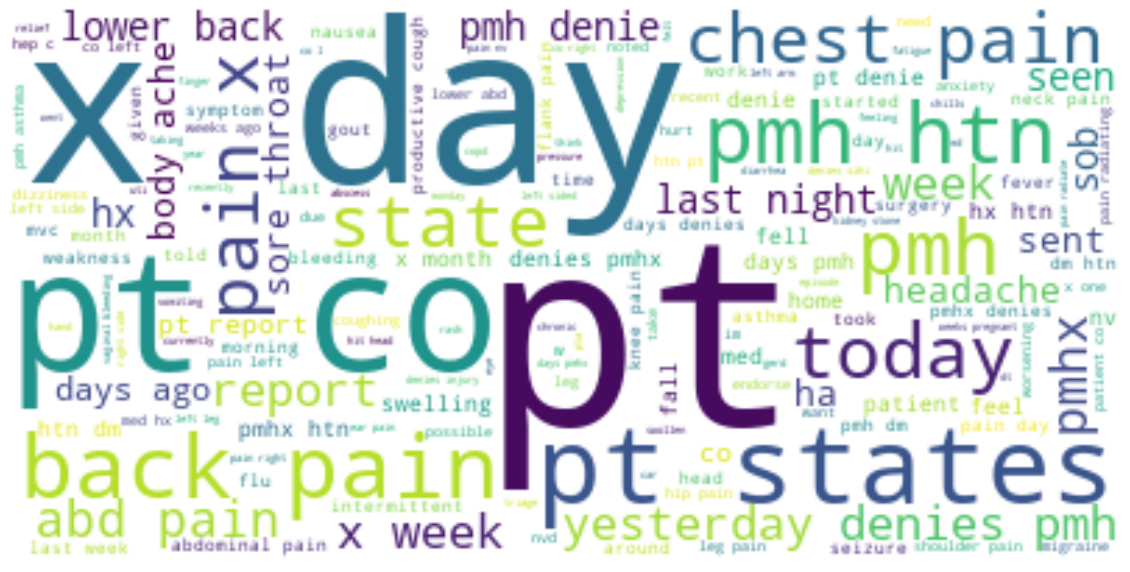

In [37]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
wordcloud_spam = WordCloud(background_color="white").generate(final_text_spam)

# Lines 2 - 5
plt.figure(figsize = (20,20))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()

In [38]:
### slice the 'gout' patients into separate df for visualization
yes_gout = df.loc[df['target'] == 'Y']
yes_gout

,corpus,target
1,"[cant, walk, reports, onset, oriented, aortic,...",Y
2,"[dehydration, chest, hurts, hips, hurt, cramps...",Y
3,"[gout, flare, l, arm, swelling, x, week, denie...",Y
6,"[think, gout, flare, l, wrist, pain, swelling,...",Y
7,"[want, see, infection, pt, vague, symptoms, go...",Y
...,...,...
4412,"[sent, usa, swelling, l, knee, sicne, pmhx, ht...",Y
5744,"[hear, treatment, lle, dvt, diagnosed, also, c...",Y
5761,"[left, foot, pain, chronic, worse, tonight, pm...",Y
8169,"[pt, co, left, elbow, pain, states, gout, flar...",Y


In [39]:
#slice the patients that do not have gout for comparison
no_gout = df.loc[df['target'] == 'N']

In [40]:
#Prior to vectorization lets make a copy of the cleaned df for analysis portion
all_df = df.copy(deep=True)

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 1))
vectorized = vectorizer.fit_transform(all_df['corpus'].astype(str))
vectored_data = pd.DataFrame.sparse.from_spmatrix(vectorized, columns=vectorizer.get_feature_names())

In [42]:
allData = vectored_data.sum(axis=0)
allData = allData.sort_values(ascending=False).head(50)
allData

pain         4500
pt           3450
pmh          3070
denies       2344
co           2153
days         1580
htn          1578
pmhx         1305
states       1264
left         1119
back         1081
since        1069
right         966
hx            954
last          842
chest         713
ago           695
weeks         631
dm            623
cough         622
lower         622
week          617
reports       615
today         576
yesterday     555
sob           549
abd           529
seen          451
nv            449
nausea        433
also          431
cp            405
night         393
ha            387
day           381
leg           376
blood         373
head          372
swelling      359
side          356
patient       356
started       352
asthma        350
neck          350
gout          346
sent          342
body          332
arm           325
loc           320
throat        318
dtype: int64

<AxesSubplot:>

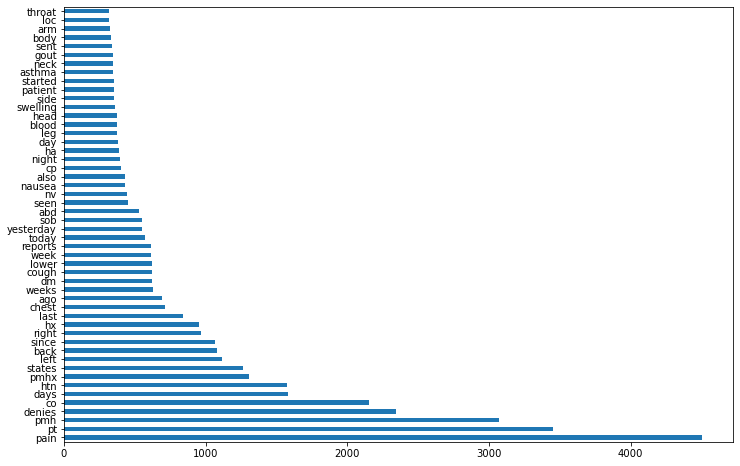

In [43]:
#plot of whole corpus
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
allData.plot.barh()

In [44]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
vectorized = vectorizer.fit_transform(yes_gout['corpus'].astype(str))
gout_data = pd.DataFrame.sparse.from_spmatrix(vectorized, columns=vectorizer.get_feature_names())

In [45]:
gout_pos = gout_data.sum(axis=0)
gout_pos = gout_pos.sort_values(ascending=False).head(10)
gout_pos

gout        149
pain        105
pmh          50
htn          46
pt           38
denies       31
knee         29
swelling     29
co           26
foot         26
dtype: int64

<AxesSubplot:>

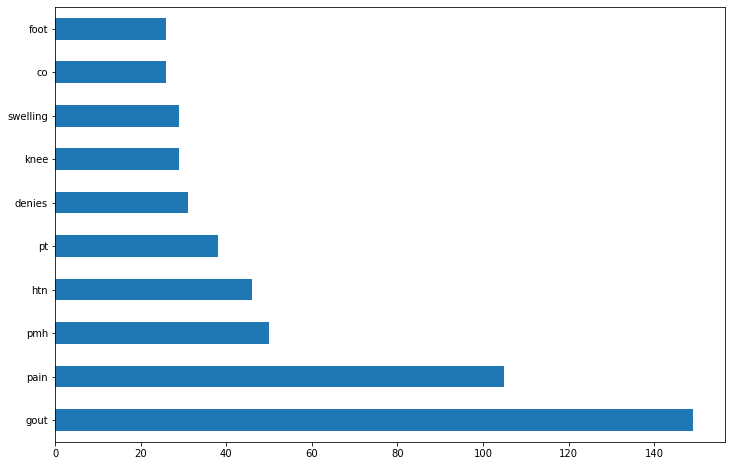

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
gout_pos.plot.barh()

**DATA FOR GOUT-NEGATIVE ONLY**

In [47]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
vectorized = vectorizer.fit_transform(no_gout['corpus'].astype(str))
nogout_data = pd.DataFrame.sparse.from_spmatrix(vectorized, columns=vectorizer.get_feature_names())

In [48]:
gout_neg = nogout_data.sum(axis=0)
gout_neg = gout_neg.sort_values(ascending=False).head(10)
gout_neg

pain      4395
pt        3412
pmh       3020
denies    2313
co        2127
days      1558
htn       1532
pmhx      1283
states    1248
left      1095
dtype: int64

<AxesSubplot:>

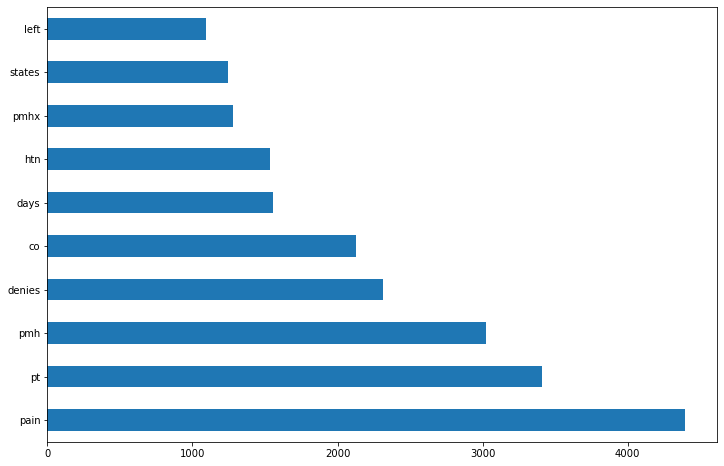

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
gout_neg.plot.barh()

In [50]:
ngout = gout_neg.to_frame().reset_index()
ygout = gout_pos.to_frame().reset_index()
ngout['r'] = 'n'
ygout['r'] = 'y'

In [51]:
ngout = ngout.rename(columns={0: 'count'})
ygout = ygout.rename(columns={0: 'count'})

In [52]:
compare = pd.concat([ngout, ygout])
compare

,index,count,r
0,pain,4395,n
1,pt,3412,n
2,pmh,3020,n
3,denies,2313,n
4,co,2127,n
5,days,1558,n
6,htn,1532,n
7,pmhx,1283,n
8,states,1248,n
9,left,1095,n


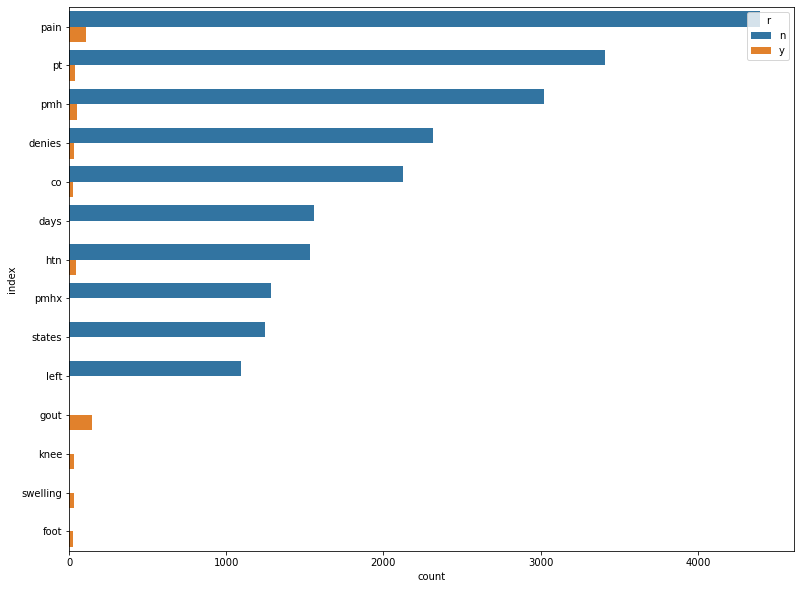

In [53]:
import seaborn as sns
fig_dims = (13, 10)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x="count", y="index", hue="r", ax=ax, data=compare)

### We see a nice separation of tokens with the expected overlap of 'pain, left, right, and dm (diabetes), with separations occuring on lung and abdominal complaints versus swelling and joint complaints.  Looks good